# Loading libraries

In [99]:
import os
import tensorflow.keras

import numpy as np
import pandas as pd
import tensorflow as tf
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import precision_score, recall_score, classification_report, confusion_matrix, f1_score, roc_auc_score, confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder, KBinsDiscretizer
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Activation, LeakyReLU, ReLU, Flatten, BatchNormalization, Input, Reshape, Conv2D, MaxPooling2D
from tensorflow.keras.activations import relu,sigmoid,softmax

# Loading the data

In [2]:
PC_USER = 'veronicalarroy'

DATA_PATH = f'/Users/{PC_USER}/data/isic-2024-challenge'

flattened_images_csv_path = f'{DATA_PATH}/temp/flattened_images.csv'

In [29]:
for _, _, filenames in os.walk(f'{DATA_PATH}/train-image/image'):
    all_images = filenames

all_images_dfs = []

i = 0

print(f"Flattenning {len(all_images)} images...")

last_percentage = -1

for image_name in all_images:

    i = i+1
    percentage = int((i/len(all_images))*100)

    image_code = image_name.replace('.jpg','')

    if last_percentage != percentage:
        print(f"{percentage}%: Flattened {i}/{len(all_images)} image")
        last_percentage = percentage

    image_name = f"{DATA_PATH}/train-image/image/{image_name}"

    image = load_img(image_name, color_mode='grayscale')

    image_array = img_to_array(image) / 255.0

    image_resized = tf.image.resize(image_array, (32, 32))

    image_numpy = image_resized.numpy()

    flattened_image = image_numpy.flatten()

    df = pd.DataFrame([flattened_image])
    df["image_code"] = image_code

    all_images_dfs.append(df)

final_df = pd.concat(all_images_dfs, ignore_index=True)

final_df.to_csv(flattened_images_csv_path, sep='|', index=False)

Loading 401059 images...
0%: Loading 1/401059 image
1%: Loading 4011/401059 image
2%: Loading 8022/401059 image
3%: Loading 12032/401059 image
4%: Loading 16043/401059 image
5%: Loading 20053/401059 image
6%: Loading 24064/401059 image
7%: Loading 28075/401059 image
8%: Loading 32085/401059 image
9%: Loading 36096/401059 image
10%: Loading 40106/401059 image
11%: Loading 44117/401059 image
12%: Loading 48128/401059 image
13%: Loading 52138/401059 image
14%: Loading 56149/401059 image
15%: Loading 60159/401059 image
16%: Loading 64170/401059 image
17%: Loading 68181/401059 image
18%: Loading 72191/401059 image
19%: Loading 76202/401059 image
20%: Loading 80212/401059 image
21%: Loading 84223/401059 image
22%: Loading 88233/401059 image
23%: Loading 92244/401059 image
24%: Loading 96255/401059 image
25%: Loading 100265/401059 image
26%: Loading 104276/401059 image
27%: Loading 108286/401059 image
28%: Loading 112297/401059 image
29%: Loading 116308/401059 image
30%: Loading 120318/401059

In [3]:
df = pd.read_csv(flattened_images_csv_path, sep='|')

df.head()

,0,1,2,3,4,5,6,7,8,9,...,1015,1016,1017,1018,1019,1020,1021,1022,1023,image_code
0,0.616606,0.577267,0.613872,0.637371,0.635075,0.677866,0.585968,0.600151,0.567982,0.627022,...,0.602912,0.633121,0.641115,0.575315,0.603598,0.613399,0.646135,0.634868,0.634188,ISIC_9212838
1,0.478493,0.466725,0.421385,0.372685,0.393321,0.387633,0.425748,0.470541,0.471569,0.449571,...,0.549632,0.559865,0.526887,0.551950,0.548950,0.537520,0.537863,0.552130,0.564766,ISIC_7419042
2,0.585056,0.651062,0.652791,0.672380,0.656003,0.675552,0.675358,0.690664,0.669301,0.645956,...,0.656732,0.627902,0.640406,0.633198,0.635294,0.611318,0.625947,0.612152,0.592538,ISIC_4607958
3,0.533248,0.483118,0.473112,0.477292,0.519054,0.467162,0.458503,0.547567,0.619505,0.390867,...,0.552022,0.552574,0.527569,0.528597,0.569337,0.497210,0.513868,0.495018,0.506924,ISIC_2314849
4,0.647059,0.648162,0.660705,0.648713,0.634649,0.644948,0.607822,0.582543,0.611128,0.622100,...,0.617279,0.618873,0.613635,0.619430,0.584375,0.602756,0.627022,0.642437,0.643137,ISIC_1432149


In [4]:
df_meta= pd.read_csv(
    f"{DATA_PATH}/train-metadata.csv",
    dtype = {
        'isic_id': 'string',
        'target': 'int64',
        'patient_id': 'string',
        'age_approx': 'float64',
        'sex': 'string',
        'anatom_site_general': 'string',
        'clin_size_long_diam_mm': 'float64',
        'image_type': 'string',
        'tbp_tile_type': 'string',
        'tbp_lv_A': 'float64',
        'tbp_lv_Aext': 'float64',
        'tbp_lv_B': 'float64',
        'tbp_lv_Bext': 'float64',
        'tbp_lv_C': 'float64',
        'tbp_lv_Cext': 'float64',
        'tbp_lv_H': 'float64',
        'tbp_lv_Hext': 'float64',
        'tbp_lv_L': 'float64',
        'tbp_lv_Lext': 'float64',
        'tbp_lv_areaMM2': 'float64',
        'tbp_lv_area_perim_ratio': 'float64',
        'tbp_lv_color_std_mean': 'float64',
        'tbp_lv_deltaA': 'float64',
        'tbp_lv_deltaB': 'float64',
        'tbp_lv_deltaL': 'float64',
        'tbp_lv_deltaLB': 'float64',
        'tbp_lv_deltaLBnorm': 'float64',
        'tbp_lv_eccentricity': 'float64',
        'tbp_lv_location': 'string',
        'tbp_lv_location_simple': 'string',
        'tbp_lv_minorAxisMM': 'float64',
        'tbp_lv_nevi_confidence': 'float64',
        'tbp_lv_norm_border': 'float64',
        'tbp_lv_norm_color': 'float64',
        'tbp_lv_perimeterMM': 'float64',
        'tbp_lv_radial_color_std_max': 'float64',
        'tbp_lv_stdL': 'float64',
        'tbp_lv_stdLExt': 'float64',
        'tbp_lv_symm_2axis': 'float64',
        'tbp_lv_symm_2axis_angle': 'int64',
        'tbp_lv_x': 'float64',
        'tbp_lv_y': 'float64',
        'tbp_lv_z': 'float64',
        'attribution': 'string',
        'copyright_license': 'string',
        'lesion_id': 'string',
        'iddx_full': 'string',
        'iddx_1': 'string',
        'iddx_2': 'string',
        'iddx_3': 'string',
        'iddx_4': 'string',
        'iddx_5': 'string',
        'mel_mitotic_index': 'string',
        'mel_thick_mm': 'float64',
        'tbp_lv_dnn_lesion_confidence': 'float64'
    }
)

df_meta.head()

,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,...,lesion_id,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence
0,ISIC_0015670,0,IP_1235828,60.0,male,lower extremity,3.04,TBP tile: close-up,3D: white,20.244422,...,<NA>,Benign,Benign,<NA>,<NA>,<NA>,<NA>,<NA>,NaN,97.517282
1,ISIC_0015845,0,IP_8170065,60.0,male,head/neck,1.10,TBP tile: close-up,3D: white,31.712570,...,IL_6727506,Benign,Benign,<NA>,<NA>,<NA>,<NA>,<NA>,NaN,3.141455
2,ISIC_0015864,0,IP_6724798,60.0,male,posterior torso,3.40,TBP tile: close-up,3D: XP,22.575830,...,<NA>,Benign,Benign,<NA>,<NA>,<NA>,<NA>,<NA>,NaN,99.804040
3,ISIC_0015902,0,IP_4111386,65.0,male,anterior torso,3.22,TBP tile: close-up,3D: XP,14.242329,...,<NA>,Benign,Benign,<NA>,<NA>,<NA>,<NA>,<NA>,NaN,99.989998
4,ISIC_0024200,0,IP_8313778,55.0,male,anterior torso,2.73,TBP tile: close-up,3D: white,24.725520,...,<NA>,Benign,Benign,<NA>,<NA>,<NA>,<NA>,<NA>,NaN,70.442510


# Small Exploratory Data Analysis (EDA)

/var/folders/m3/cvmhd4j11f7968wyg9z4qfdr0000gn/T/ipykernel_768/3501452476.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  str(melanoma_counts[i]), ha='center', va='bottom')


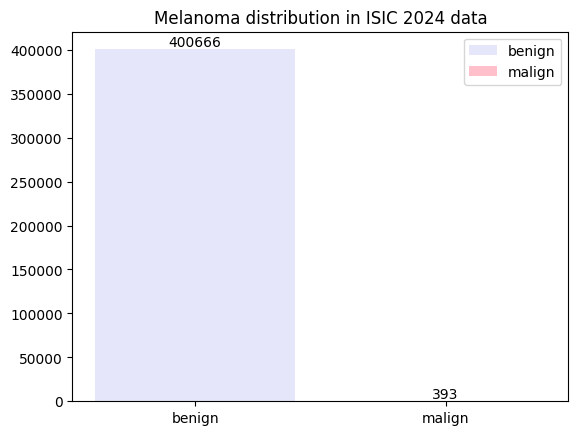

In [151]:
melanoma_counts = pd.Series({'benign': 400666, 'malign': 393})

colors = ['lavender', 'pink']
bars = plt.bar(melanoma_counts.index, melanoma_counts, color=colors)

for i, bar in enumerate(bars):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 1, 
             str(melanoma_counts[i]), ha='center', va='bottom')

plt.legend(bars, ['benign', 'malign'])
plt.title("Melanoma distribution in ISIC 2024 data")

plt.show()

# Resampling to have the data more balanced

In [5]:
df_meta.rename(columns={"isic_id": "image_code"}, inplace=True)

Merge df and df_meta on 'image_code'

In [6]:
merged_df = pd.merge(df, df_meta, on='image_code')

Split the data into benign (0) and malign (1)

In [7]:
benign_df = merged_df[merged_df['target'] == 0]
malign_df = merged_df[merged_df['target'] == 1]

Select randomly 3000 rows from the benign_df (downsampling)

In [8]:
sampled_benign_df = benign_df.sample(n=3000, random_state=42)

Combining the 3000 benign with all maligns

In [9]:
final_df = pd.concat([sampled_benign_df, malign_df])

In [10]:
final_df = final_df.reset_index(drop=True)

Splitting back the final_df into images_df and meta_df

In [11]:
image_columns = df.columns.tolist() 
meta_columns = df_meta.columns.tolist()

In [12]:
image_columns_with_target = image_columns + ['target']

image_df = final_df[image_columns_with_target]
meta_df = final_df[meta_columns]

In [13]:
image_df["target"].value_counts()

target
0    3000
1     393
Name: count, dtype: int64

/var/folders/m3/cvmhd4j11f7968wyg9z4qfdr0000gn/T/ipykernel_768/2993845162.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  str(melanoma_counts[i]), ha='center', va='bottom')


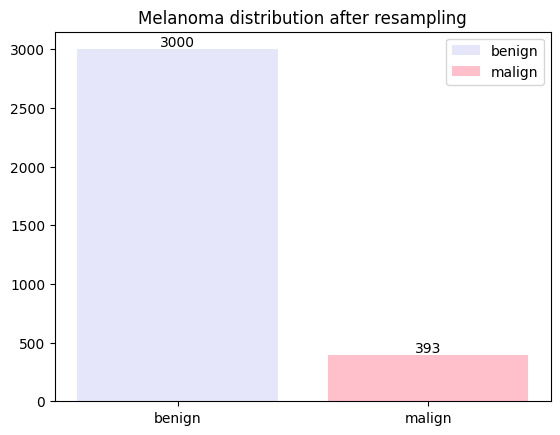

In [161]:
melanoma_counts = pd.Series({'benign': 3000, 'malign': 393})

colors = ['lavender', 'pink']
bars = plt.bar(melanoma_counts.index, melanoma_counts, color=colors)

for i, bar in enumerate(bars):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 1, 
             str(melanoma_counts[i]), ha='center', va='bottom')

plt.legend(bars, ['benign', 'malign'])
plt.title("Melanoma distribution after resampling")

plt.show()

### Checking for null values in meta df

In [162]:
meta_df.isnull().sum()

image_code                         0
target                             0
patient_id                         0
age_approx                        36
sex                              103
anatom_site_general               40
clin_size_long_diam_mm             0
image_type                         0
tbp_tile_type                      0
tbp_lv_A                           0
tbp_lv_Aext                        0
tbp_lv_B                           0
tbp_lv_Bext                        0
tbp_lv_C                           0
tbp_lv_Cext                        0
tbp_lv_H                           0
tbp_lv_Hext                        0
tbp_lv_L                           0
tbp_lv_Lext                        0
tbp_lv_areaMM2                     0
tbp_lv_area_perim_ratio            0
tbp_lv_color_std_mean              0
tbp_lv_deltaA                      0
tbp_lv_deltaB                      0
tbp_lv_deltaL                      0
tbp_lv_deltaLB                     0
tbp_lv_deltaLBnorm                 0
t

#### Dropping columns with a lot of nulls

In [14]:
meta_df.drop(columns=["lesion_id", "iddx_2", "iddx_3", "iddx_4", "iddx_5", "mel_mitotic_index", "mel_thick_mm"], inplace = True)

/var/folders/m3/cvmhd4j11f7968wyg9z4qfdr0000gn/T/ipykernel_3780/3345843454.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meta_df.drop(columns=["lesion_id", "iddx_2", "iddx_3", "iddx_4", "iddx_5", "mel_mitotic_index", "mel_thick_mm"], inplace = True)


### Label Encoding

#### Sex

In [15]:
meta_df['sex'].fillna('unkown',inplace = True)

/var/folders/m3/cvmhd4j11f7968wyg9z4qfdr0000gn/T/ipykernel_3780/1339829970.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  meta_df['sex'].fillna('unkown',inplace = True)
/var/folders/m3/cvmhd4j11f7968wyg9z4qfdr0000gn/T/ipykernel_3780/1339829970.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meta_df['sex'].fillna('unkown',inplace = Tru

In [17]:
enc = LabelEncoder()

In [18]:
df_meta['sex_enc'] = enc.fit_transform(df_meta.sex.astype('str'))

<Axes: xlabel='sex', ylabel='count'>

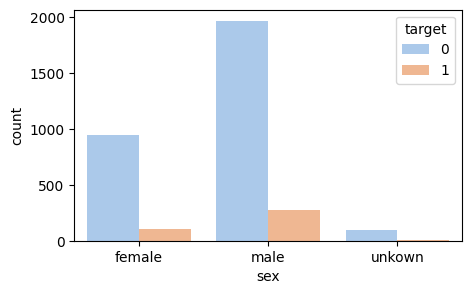

In [167]:
plt.figure(figsize = (5,3))
sns.countplot(x = 'sex', hue = 'target', data = meta_df, palette="pastel")

#### Anatom_site_general

In [19]:
meta_df.anatom_site_general = meta_df.anatom_site_general.fillna('unknown')

/var/folders/m3/cvmhd4j11f7968wyg9z4qfdr0000gn/T/ipykernel_3780/317952653.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meta_df.anatom_site_general = meta_df.anatom_site_general.fillna('unknown')


In [20]:
meta_df['anatom_enc']= enc.fit_transform(meta_df.anatom_site_general.astype('str'))

/var/folders/m3/cvmhd4j11f7968wyg9z4qfdr0000gn/T/ipykernel_3780/3412701113.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meta_df['anatom_enc']= enc.fit_transform(meta_df.anatom_site_general.astype('str'))


#### Age

In [21]:
meta_df['age_approx'] = meta_df['age_approx'].fillna(meta_df['age_approx'].mode().values[0])

/var/folders/m3/cvmhd4j11f7968wyg9z4qfdr0000gn/T/ipykernel_3780/2330521329.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meta_df['age_approx'] = meta_df['age_approx'].fillna(meta_df['age_approx'].mode().values[0])


In [22]:
meta_df['age_enc']= enc.fit_transform(meta_df['age_approx'].astype('str'))

/var/folders/m3/cvmhd4j11f7968wyg9z4qfdr0000gn/T/ipykernel_3780/131906799.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meta_df['age_enc']= enc.fit_transform(meta_df['age_approx'].astype('str'))


<Axes: xlabel='age_approx', ylabel='count'>

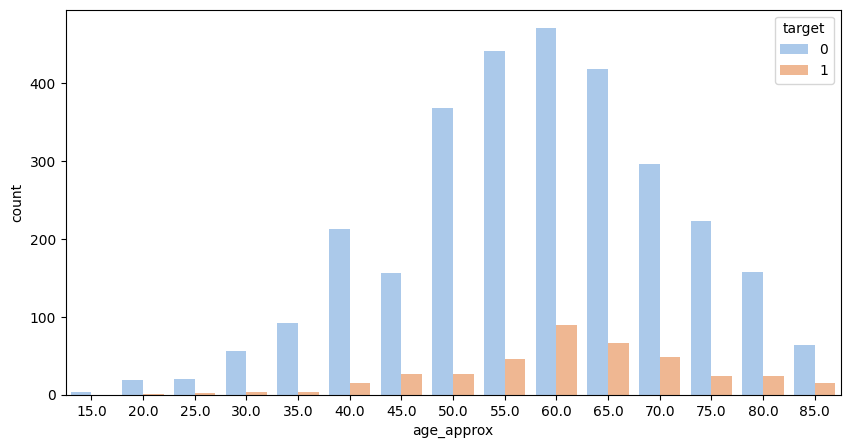

In [172]:
plt.figure(figsize = (10,5))
sns.countplot(x = 'age_approx', hue = 'target', data = meta_df, palette="pastel")

#### Images per patient

In [23]:
meta_df['n_images'] = meta_df.patient_id.map(meta_df.groupby(['patient_id']).image_code.count())

/var/folders/m3/cvmhd4j11f7968wyg9z4qfdr0000gn/T/ipykernel_3780/1192466346.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meta_df['n_images'] = meta_df.patient_id.map(meta_df.groupby(['patient_id']).image_code.count())


#### Categorize number of images per patient

In [24]:
categorize = KBinsDiscretizer(n_bins = 10, encode = 'ordinal', strategy = 'uniform')
meta_df['n_images_enc'] = categorize.fit_transform(meta_df['n_images'].values.reshape(-1, 1)).astype(int).squeeze()

/var/folders/m3/cvmhd4j11f7968wyg9z4qfdr0000gn/T/ipykernel_3780/3850387019.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meta_df['n_images_enc'] = categorize.fit_transform(meta_df['n_images'].values.reshape(-1, 1)).astype(int).squeeze()


<Axes: xlabel='n_images_enc', ylabel='count'>

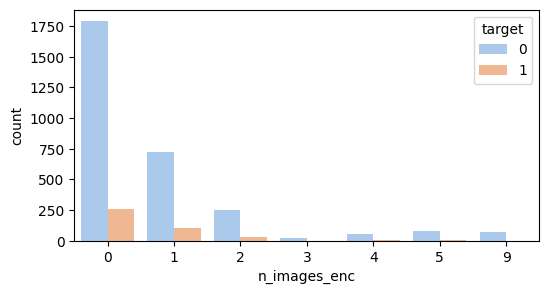

In [103]:
plt.figure(figsize = (6,3))
sns.countplot(x = 'n_images_enc', hue = 'target', data = meta_df, palette="pastel")

#### tbp tile type

In [25]:
meta_df['tbp_tile_type_enc']= enc.fit_transform(meta_df.tbp_tile_type.astype('str'))

/var/folders/m3/cvmhd4j11f7968wyg9z4qfdr0000gn/T/ipykernel_3780/3449909726.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meta_df['tbp_tile_type_enc']= enc.fit_transform(meta_df.tbp_tile_type.astype('str'))


#### iddx_full

In [26]:
meta_df['iddx_full_enc']= enc.fit_transform(meta_df.iddx_full.astype('str'))

/var/folders/m3/cvmhd4j11f7968wyg9z4qfdr0000gn/T/ipykernel_3780/3492704478.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meta_df['iddx_full_enc']= enc.fit_transform(meta_df.iddx_full.astype('str'))


#### iddx-1

In [27]:
meta_df['iddx_1_enc']= enc.fit_transform(meta_df.iddx_1.astype('str'))

/var/folders/m3/cvmhd4j11f7968wyg9z4qfdr0000gn/T/ipykernel_3780/356719107.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meta_df['iddx_1_enc']= enc.fit_transform(meta_df.iddx_1.astype('str'))


#### tbp_lv_location

In [28]:
meta_df['tbp_lv_location_enc']= enc.fit_transform(meta_df.tbp_lv_location.astype('str'))

/var/folders/m3/cvmhd4j11f7968wyg9z4qfdr0000gn/T/ipykernel_3780/1783935138.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meta_df['tbp_lv_location_enc']= enc.fit_transform(meta_df.tbp_lv_location.astype('str'))


#### tbp_lv_location_simple

In [29]:
meta_df['tbp_lv_location_simple_enc']= enc.fit_transform(meta_df.tbp_lv_location_simple.astype('str'))

/var/folders/m3/cvmhd4j11f7968wyg9z4qfdr0000gn/T/ipykernel_3780/1771079654.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meta_df['tbp_lv_location_simple_enc']= enc.fit_transform(meta_df.tbp_lv_location_simple.astype('str'))


## meta_df feature selection

In [30]:
pd.set_option('display.max_columns',None)

In [31]:
meta_df.head(1)

,image_code,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,tbp_lv_Aext,tbp_lv_B,tbp_lv_Bext,tbp_lv_C,tbp_lv_Cext,tbp_lv_H,tbp_lv_Hext,tbp_lv_L,tbp_lv_Lext,tbp_lv_areaMM2,tbp_lv_area_perim_ratio,tbp_lv_color_std_mean,tbp_lv_deltaA,tbp_lv_deltaB,tbp_lv_deltaL,tbp_lv_deltaLB,tbp_lv_deltaLBnorm,tbp_lv_eccentricity,tbp_lv_location,tbp_lv_location_simple,tbp_lv_minorAxisMM,tbp_lv_nevi_confidence,tbp_lv_norm_border,tbp_lv_norm_color,tbp_lv_perimeterMM,tbp_lv_radial_color_std_max,tbp_lv_stdL,tbp_lv_stdLExt,tbp_lv_symm_2axis,tbp_lv_symm_2axis_angle,tbp_lv_x,tbp_lv_y,tbp_lv_z,attribution,copyright_license,iddx_full,iddx_1,tbp_lv_dnn_lesion_confidence,anatom_enc,age_enc,n_images,n_images_enc,tbp_tile_type_enc,iddx_full_enc,iddx_1_enc,tbp_lv_location_enc,tbp_lv_location_simple_enc
0,ISIC_6816024,0,IP_1132945,55.0,female,anterior torso,3.6,TBP tile: close-up,3D: XP,17.40398,9.359642,32.72831,27.611985,37.068057,29.155182,61.997232,71.274869,49.147174,59.318115,7.26215,16.571909,1.518484,8.044337,5.116325,-10.170941,11.485284,8.490698,0.745669,Torso Front Top Half,Torso Front,2.499998,99.789667,2.361088,4.507353,10.97031,1.489583,3.316372,2.068222,0.220183,40,-89.03299,1099.248657,-136.759766,University Hospital of Basel,CC-BY-NC,Benign,Benign,100.0,0,8,1,0,0,0,0,18,6


## Important note!!

Whenever runing the code, ensure that you drop ALL the columns that have been encoded, because correlation matrices and ML algorithms do not work with strings. 

Use the following code: df_meta.drop(columns= ["column_a", "column_b"], inplace=True)

In [32]:
meta_df.drop(columns= [
   "tbp_lv_location", "tbp_lv_location_simple", "patient_id",
   "age_approx", "sex", "anatom_site_general", "image_type", "tbp_tile_type",
   "tbp_lv_location", "tbp_lv_location_simple", "attribution", "copyright_license",
   "iddx_full", "iddx_1"
 ], inplace=True)

/var/folders/m3/cvmhd4j11f7968wyg9z4qfdr0000gn/T/ipykernel_3780/4276330604.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meta_df.drop(columns= [


In [33]:
meta_df.head()

,image_code,target,clin_size_long_diam_mm,tbp_lv_A,tbp_lv_Aext,tbp_lv_B,tbp_lv_Bext,tbp_lv_C,tbp_lv_Cext,tbp_lv_H,tbp_lv_Hext,tbp_lv_L,tbp_lv_Lext,tbp_lv_areaMM2,tbp_lv_area_perim_ratio,tbp_lv_color_std_mean,tbp_lv_deltaA,tbp_lv_deltaB,tbp_lv_deltaL,tbp_lv_deltaLB,tbp_lv_deltaLBnorm,tbp_lv_eccentricity,tbp_lv_minorAxisMM,tbp_lv_nevi_confidence,tbp_lv_norm_border,tbp_lv_norm_color,tbp_lv_perimeterMM,tbp_lv_radial_color_std_max,tbp_lv_stdL,tbp_lv_stdLExt,tbp_lv_symm_2axis,tbp_lv_symm_2axis_angle,tbp_lv_x,tbp_lv_y,tbp_lv_z,tbp_lv_dnn_lesion_confidence,anatom_enc,age_enc,n_images,n_images_enc,tbp_tile_type_enc,iddx_full_enc,iddx_1_enc,tbp_lv_location_enc,tbp_lv_location_simple_enc
0,ISIC_6816024,0,3.60,17.403980,9.359642,32.728310,27.611985,37.068057,29.155182,61.997232,71.274869,49.147174,59.318115,7.262150,16.571909,1.518484,8.044337,5.116325,-10.170941,11.485284,8.490698,0.745669,2.499998,99.789667,2.361088,4.507353,10.970310,1.489583,3.316372,2.068222,0.220183,40,-89.032990,1099.248657,-136.759766,100.000000,0,8,1,0,0,0,0,18,6
1,ISIC_7179031,0,3.29,19.807330,15.694290,26.838100,25.990200,33.355870,30.361180,53.571550,58.874140,25.097420,32.273560,5.967348,15.966200,0.430872,4.113040,0.847902,-7.176132,7.343341,7.945036,0.771062,2.191781,89.749210,2.369807,1.322378,9.760936,0.451078,1.917072,1.125674,0.236264,55,-258.351900,1296.501000,147.697500,99.999920,5,8,2,0,0,0,0,3,1
2,ISIC_9836856,0,4.58,16.896179,13.025438,22.348817,21.733907,28.016967,25.338207,52.909947,59.065145,22.629900,29.198839,8.069056,23.681788,1.071097,3.870740,0.614910,-6.568940,6.713932,7.832114,0.897321,2.192788,2.661496,3.716402,3.622970,13.823519,1.341007,2.356845,2.044722,0.228216,10,416.137512,1247.750732,112.024902,92.036825,5,13,16,2,0,0,0,3,1
3,ISIC_4062757,0,2.88,21.487189,15.261616,24.046405,19.921275,32.247928,25.095301,48.216925,52.544407,55.708370,64.886441,4.822668,15.548284,0.717553,6.225573,4.125130,-9.178072,10.145551,6.854720,0.685693,2.054795,76.106584,1.951989,2.087786,8.659343,0.676317,2.781081,1.946605,0.190141,85,199.871033,631.030701,156.308380,99.999964,2,3,4,0,1,0,0,12,4
4,ISIC_5910482,0,2.90,16.094396,9.974178,23.528442,21.773732,28.506441,23.949523,55.626310,65.388286,34.398283,48.485230,6.661663,14.011395,2.946391,6.120218,1.754710,-14.086946,14.449472,12.268974,0.441474,2.670960,99.316484,1.630953,7.998123,9.661221,2.401003,6.121249,2.103177,0.184615,170,77.189575,635.162598,93.152832,100.000000,2,9,7,0,0,0,0,6,2


In [35]:
sprmdl_meta = meta_df.copy()
sprmdl_meta.head()

,image_code,target,clin_size_long_diam_mm,tbp_lv_A,tbp_lv_Aext,tbp_lv_B,tbp_lv_Bext,tbp_lv_C,tbp_lv_Cext,tbp_lv_H,tbp_lv_Hext,tbp_lv_L,tbp_lv_Lext,tbp_lv_areaMM2,tbp_lv_area_perim_ratio,tbp_lv_color_std_mean,tbp_lv_deltaA,tbp_lv_deltaB,tbp_lv_deltaL,tbp_lv_deltaLB,tbp_lv_deltaLBnorm,tbp_lv_eccentricity,tbp_lv_minorAxisMM,tbp_lv_nevi_confidence,tbp_lv_norm_border,tbp_lv_norm_color,tbp_lv_perimeterMM,tbp_lv_radial_color_std_max,tbp_lv_stdL,tbp_lv_stdLExt,tbp_lv_symm_2axis,tbp_lv_symm_2axis_angle,tbp_lv_x,tbp_lv_y,tbp_lv_z,tbp_lv_dnn_lesion_confidence,anatom_enc,age_enc,n_images,n_images_enc,tbp_tile_type_enc,iddx_full_enc,iddx_1_enc,tbp_lv_location_enc,tbp_lv_location_simple_enc
0,ISIC_6816024,0,3.60,17.403980,9.359642,32.728310,27.611985,37.068057,29.155182,61.997232,71.274869,49.147174,59.318115,7.262150,16.571909,1.518484,8.044337,5.116325,-10.170941,11.485284,8.490698,0.745669,2.499998,99.789667,2.361088,4.507353,10.970310,1.489583,3.316372,2.068222,0.220183,40,-89.032990,1099.248657,-136.759766,100.000000,0,8,1,0,0,0,0,18,6
1,ISIC_7179031,0,3.29,19.807330,15.694290,26.838100,25.990200,33.355870,30.361180,53.571550,58.874140,25.097420,32.273560,5.967348,15.966200,0.430872,4.113040,0.847902,-7.176132,7.343341,7.945036,0.771062,2.191781,89.749210,2.369807,1.322378,9.760936,0.451078,1.917072,1.125674,0.236264,55,-258.351900,1296.501000,147.697500,99.999920,5,8,2,0,0,0,0,3,1
2,ISIC_9836856,0,4.58,16.896179,13.025438,22.348817,21.733907,28.016967,25.338207,52.909947,59.065145,22.629900,29.198839,8.069056,23.681788,1.071097,3.870740,0.614910,-6.568940,6.713932,7.832114,0.897321,2.192788,2.661496,3.716402,3.622970,13.823519,1.341007,2.356845,2.044722,0.228216,10,416.137512,1247.750732,112.024902,92.036825,5,13,16,2,0,0,0,3,1
3,ISIC_4062757,0,2.88,21.487189,15.261616,24.046405,19.921275,32.247928,25.095301,48.216925,52.544407,55.708370,64.886441,4.822668,15.548284,0.717553,6.225573,4.125130,-9.178072,10.145551,6.854720,0.685693,2.054795,76.106584,1.951989,2.087786,8.659343,0.676317,2.781081,1.946605,0.190141,85,199.871033,631.030701,156.308380,99.999964,2,3,4,0,1,0,0,12,4
4,ISIC_5910482,0,2.90,16.094396,9.974178,23.528442,21.773732,28.506441,23.949523,55.626310,65.388286,34.398283,48.485230,6.661663,14.011395,2.946391,6.120218,1.754710,-14.086946,14.449472,12.268974,0.441474,2.670960,99.316484,1.630953,7.998123,9.661221,2.401003,6.121249,2.103177,0.184615,170,77.189575,635.162598,93.152832,100.000000,2,9,7,0,0,0,0,6,2


In [36]:
meta_df.drop(columns=["image_code"], inplace=True)
meta_df.head()

/var/folders/m3/cvmhd4j11f7968wyg9z4qfdr0000gn/T/ipykernel_3780/537535525.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meta_df.drop(columns=["image_code"], inplace=True)


,target,clin_size_long_diam_mm,tbp_lv_A,tbp_lv_Aext,tbp_lv_B,tbp_lv_Bext,tbp_lv_C,tbp_lv_Cext,tbp_lv_H,tbp_lv_Hext,tbp_lv_L,tbp_lv_Lext,tbp_lv_areaMM2,tbp_lv_area_perim_ratio,tbp_lv_color_std_mean,tbp_lv_deltaA,tbp_lv_deltaB,tbp_lv_deltaL,tbp_lv_deltaLB,tbp_lv_deltaLBnorm,tbp_lv_eccentricity,tbp_lv_minorAxisMM,tbp_lv_nevi_confidence,tbp_lv_norm_border,tbp_lv_norm_color,tbp_lv_perimeterMM,tbp_lv_radial_color_std_max,tbp_lv_stdL,tbp_lv_stdLExt,tbp_lv_symm_2axis,tbp_lv_symm_2axis_angle,tbp_lv_x,tbp_lv_y,tbp_lv_z,tbp_lv_dnn_lesion_confidence,anatom_enc,age_enc,n_images,n_images_enc,tbp_tile_type_enc,iddx_full_enc,iddx_1_enc,tbp_lv_location_enc,tbp_lv_location_simple_enc
0,0,3.60,17.403980,9.359642,32.728310,27.611985,37.068057,29.155182,61.997232,71.274869,49.147174,59.318115,7.262150,16.571909,1.518484,8.044337,5.116325,-10.170941,11.485284,8.490698,0.745669,2.499998,99.789667,2.361088,4.507353,10.970310,1.489583,3.316372,2.068222,0.220183,40,-89.032990,1099.248657,-136.759766,100.000000,0,8,1,0,0,0,0,18,6
1,0,3.29,19.807330,15.694290,26.838100,25.990200,33.355870,30.361180,53.571550,58.874140,25.097420,32.273560,5.967348,15.966200,0.430872,4.113040,0.847902,-7.176132,7.343341,7.945036,0.771062,2.191781,89.749210,2.369807,1.322378,9.760936,0.451078,1.917072,1.125674,0.236264,55,-258.351900,1296.501000,147.697500,99.999920,5,8,2,0,0,0,0,3,1
2,0,4.58,16.896179,13.025438,22.348817,21.733907,28.016967,25.338207,52.909947,59.065145,22.629900,29.198839,8.069056,23.681788,1.071097,3.870740,0.614910,-6.568940,6.713932,7.832114,0.897321,2.192788,2.661496,3.716402,3.622970,13.823519,1.341007,2.356845,2.044722,0.228216,10,416.137512,1247.750732,112.024902,92.036825,5,13,16,2,0,0,0,3,1
3,0,2.88,21.487189,15.261616,24.046405,19.921275,32.247928,25.095301,48.216925,52.544407,55.708370,64.886441,4.822668,15.548284,0.717553,6.225573,4.125130,-9.178072,10.145551,6.854720,0.685693,2.054795,76.106584,1.951989,2.087786,8.659343,0.676317,2.781081,1.946605,0.190141,85,199.871033,631.030701,156.308380,99.999964,2,3,4,0,1,0,0,12,4
4,0,2.90,16.094396,9.974178,23.528442,21.773732,28.506441,23.949523,55.626310,65.388286,34.398283,48.485230,6.661663,14.011395,2.946391,6.120218,1.754710,-14.086946,14.449472,12.268974,0.441474,2.670960,99.316484,1.630953,7.998123,9.661221,2.401003,6.121249,2.103177,0.184615,170,77.189575,635.162598,93.152832,100.000000,2,9,7,0,0,0,0,6,2


#### correlation matrix

In [37]:
corr = meta_df.corr(method = 'pearson')
corr = corr.abs()
corr.style.background_gradient(cmap='inferno')

,target,clin_size_long_diam_mm,tbp_lv_A,tbp_lv_Aext,tbp_lv_B,tbp_lv_Bext,tbp_lv_C,tbp_lv_Cext,tbp_lv_H,tbp_lv_Hext,tbp_lv_L,tbp_lv_Lext,tbp_lv_areaMM2,tbp_lv_area_perim_ratio,tbp_lv_color_std_mean,tbp_lv_deltaA,tbp_lv_deltaB,tbp_lv_deltaL,tbp_lv_deltaLB,tbp_lv_deltaLBnorm,tbp_lv_eccentricity,tbp_lv_minorAxisMM,tbp_lv_nevi_confidence,tbp_lv_norm_border,tbp_lv_norm_color,tbp_lv_perimeterMM,tbp_lv_radial_color_std_max,tbp_lv_stdL,tbp_lv_stdLExt,tbp_lv_symm_2axis,tbp_lv_symm_2axis_angle,tbp_lv_x,tbp_lv_y,tbp_lv_z,tbp_lv_dnn_lesion_confidence,anatom_enc,age_enc,n_images,n_images_enc,tbp_tile_type_enc,iddx_full_enc,iddx_1_enc,tbp_lv_location_enc,tbp_lv_location_simple_enc
target,1.000000,0.271207,0.188124,0.219000,0.262101,0.143702,0.097767,0.013720,0.406256,0.309620,0.039441,0.003100,0.335704,0.099082,0.221561,0.010263,0.325957,0.107501,0.116301,0.132711,0.053976,0.301351,0.141393,0.072046,0.209571,0.295789,0.235016,0.120611,0.211541,0.027334,0.001890,0.029605,0.106741,0.090618,0.336770,0.053541,0.073568,0.078367,0.074737,0.155550,0.860802,1.000000,0.120688,0.126358
clin_size_long_diam_mm,0.271207,1.000000,0.056200,0.073522,0.210432,0.082614,0.183059,0.095329,0.146813,0.012689,0.109774,0.009976,0.912810,0.517333,0.565663,0.015012,0.323418,0.294821,0.292579,0.337564,0.109873,0.896577,0.029584,0.282597,0.574592,0.973930,0.557325,0.289135,0.217798,0.020267,0.025792,0.006867,0.005323,0.020701,0.081061,0.043660,0.011568,0.036755,0.034189,0.000111,0.336481,0.271207,0.050006,0.054887
tbp_lv_A,0.188124,0.056200,1.000000,0.803338,0.344191,0.423777,0.714448,0.666425,0.577759,0.491716,0.276042,0.310163,0.048353,0.063321,0.060754,0.477693,0.014817,0.185531,0.176502,0.000050,0.051250,0.038265,0.015768,0.056007,0.073594,0.051725,0.067686,0.110870,0.103998,0.036905,0.003585,0.007909,0.234238,0.001119,0.054670,0.036108,0.014351,0.120689,0.121884,0.109015,0.077766,0.188124,0.032317,0.019989
tbp_lv_Aext,0.219000,0.073522,0.803338,1.000000,0.186505,0.306973,0.500669,0.647955,0.550263,0.763415,0.138340,0.086102,0.064993,0.123443,0.136078,0.139434,0.153741,0.132467,0.135935,0.236910,0.087938,0.096633,0.296271,0.176016,0.128752,0.049984,0.094945,0.174944,0.147114,0.195498,0.006226,0.007915,0.267855,0.011150,0.103935,0.037038,0.130341,0.032774,0.032360,0.210345,0.116420,0.219000,0.086215,0.102267
tbp_lv_B,0.262101,0.210432,0.344191,0.186505,1.000000,0.901389,0.900373,0.796326,0.544374,0.414118,0.503607,0.480344,0.224726,0.148720,0.111581,0.297183,0.578358,0.060444,0.074661,0.153805,0.020136,0.218876,0.187041,0.108276,0.101455,0.228473,0.103617,0.001092,0.119633,0.045055,0.013124,0.007341,0.271996,0.131232,0.298176,0.075889,0.105533,0.043244,0.045819,0.240176,0.224772,0.262101,0.198122,0.186444
tbp_lv_Bext,0.143702,0.082614,0.423777,0.306973,0.901389,1.000000,0.864073,0.921528,0.377587,0.358265,0.417000,0.441693,0.089506,0.089138,0.046428,0.251802,0.168083,0.192962,0.199131,0.003768,0.015687,0.090817,0.142728,0.081400,0.044033,0.098281,0.037302,0.134433,0.021935,0.059357,0.000087,0.000829,0.293063,0.155730,0.219186,0.101499,0.078017,0.062870,0.062865,0.233544,0.108577,0.143702,0.199246,0.189274
tbp_lv_C,0.097767,0.183059,0.714448,0.500669,0.900373,0.864073,1.000000,0.897165,0.137348,0.087986,0.507584,0.504348,0.188572,0.139193,0.056411,0.449383,0.421855,0.126634,0.135765,0.116826,0.007205,0.181281,0.122454,0.105009,0.043755,0.193740,0.047593,0.047129,0.039183,0.048653,0.012195,0.009176,0.311977,0.094913,0.234884,0.037586,0.070410,0.088864,0.091229,0.130204,0.126825,0.097767,0.159534,0.145201
tbp_lv_Cext,0.013720,0.095329,0.666425,0.647955,0.796326,0.921528,0.897165,1.000000,0.077330,0.020604,0.391801,0.391376,0.095491,0.025348,0.014462,0.152251,0.076741,0.104487,0.109023,0.095479,0.046724,0.110961,0.001908,0.001979,0.014723,0.098349,0.007157,0.041553,0.044578,0.028179,0.001747,0.002926,0.346104,0.122737,0.120357,0.091280,0.012756,0.067915,0.067553,0.104406,0.032117,0.013720,0.119186,0.104694
tbp_lv_H,0.406256,0.146813,0.577759,0.550263,0.544374,0.377587,0

In [38]:
meta_features = meta_df[
    [
        "clin_size_long_diam_mm", "tbp_lv_A",
        "tbp_lv_Aext", "tbp_lv_B", "tbp_lv_Bext", "tbp_lv_C", "tbp_lv_Cext",
        "tbp_lv_H", "tbp_lv_Hext", "tbp_lv_L", "tbp_lv_Lext", "tbp_lv_areaMM2",
        "tbp_lv_color_std_mean", "tbp_lv_deltaA", "tbp_lv_deltaB", "tbp_lv_deltaL",
        "tbp_lv_deltaLB", "tbp_lv_deltaLBnorm", "tbp_lv_eccentricity","iddx_full_enc", "iddx_1_enc"
    ]
]

In [39]:
meta_target = meta_df["target"]

# image_df feature/target selection

In [40]:
image_features = image_df.drop(columns=["image_code", "target"])

In [41]:
image_target = image_df["target"]

# Train/test split img/meta dfs

In [42]:
img_train, img_test, target_img_train, target_img_test = train_test_split(image_features, image_target, test_size = 0.20, random_state=0)

meta_train, meta_test, target_meta_train, target_meta_test = train_test_split(meta_features, meta_target, test_size = 0.20, random_state=0)

## Normalize the meta df
(img already normalized)

In [43]:
scaler = StandardScaler()

In [45]:
scaler.fit(meta_train)

StandardScaler()

In [46]:
meta_train_norm = scaler.transform(meta_train)

meta_test_norm = scaler.transform(meta_test)

# ML model building

## image model (CNN)

In [47]:
img_model = tf.keras.Sequential([
    tf.keras.layers.Reshape((32, 32, 1), input_shape=(1024,)), 
    tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),  # Dense layer with 128 neurons
    tf.keras.layers.Dense(2)
    ])

/Volumes/MacintoshHD/Users/veronicalarroy/Desktop/anaconda3/envs/IH_BCN_DAFT/lib/python3.11/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [48]:
img_model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy', 'mse'])

In [49]:
img_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape (Reshape)               │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 163,074 (637.01 KB)

 Trainable params: 163,074 (637.01 KB)

 Non-trainable params: 0 (0.00 B)

In [50]:
img_model.fit(img_train, target_img_train, epochs=10, validation_data=(img_test, target_img_test))

Epoch 1/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.8772 - loss: 0.4010 - mse: 1.1679 - val_accuracy: 0.8733 - val_loss: 0.3783 - val_mse: 1.0280
Epoch 2/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.8937 - loss: 0.3411 - mse: 1.2971 - val_accuracy: 0.8733 - val_loss: 0.3907 - val_mse: 1.7154
Epoch 3/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.8887 - loss: 0.3505 - mse: 1.5202 - val_accuracy: 0.8733 - val_loss: 0.3744 - val_mse: 1.1670
Epoch 4/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.8916 - loss: 0.3376 - mse: 1.3290 - val_accuracy: 0.8733 - val_loss: 0.3800 - val_mse: 1.6984
Epoch 5/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.8934 - loss: 0.3394 - mse: 1.5962 - val_accuracy: 0.8733 - val_loss: 0.3657 - val_mse: 1.1391
Epoch 6/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.8871 - loss: 0.3388 - mse: 1.4185 - val_accuracy: 0.8763 - val_loss: 0.3600 - val_mse: 1.8644
Epoch 7/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/

In [51]:
img_predictions = img_model.predict(img_test)

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


In [52]:
img_predictions

array([[ 1.2561766 , -0.9975785 ],
       [ 1.3463014 , -1.0485947 ],
       [-0.13736634,  0.08111872],
       ...,
       [ 2.0689023 , -1.6342653 ],
       [ 1.5749333 , -1.3138047 ],
       [ 2.0555544 , -1.6564986 ]], dtype=float32)

In [53]:
score = tf.nn.softmax(img_predictions[0])
score

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.9049739 , 0.09502605], dtype=float32)>

In [54]:
tumour = [0, 1]

In [55]:
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(tumour[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to 0 with a 90.50 percent confidence.


In [56]:
target_img_test.values[0]

0

## Metadata model (LightGBM)

In [57]:
meta_d_train = lgb.Dataset(meta_train_norm, label=target_meta_train)

meta_d_test = lgb.Dataset(meta_test_norm, label=target_meta_test)

watchlist = [meta_d_train, meta_d_test]

In [109]:
lgbm_params = {
    "learning_rate": 0.3,
    "boosting_type": "dart", #dart has been shown to prevent overfitting (see documentation)
    "objective": "binary",
    "metric": ["auc", "binary_logloss"],
    "num_leaves": 100,
    "max_depth": 10,
    'verbosity': -1
    }

 K-fold cross-validation with stratified sampling, which preserves class distribution in each fold for balanced cross-validation

In [110]:
N_FOLDS = 10
folds = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=42)

oof = np.zeros(len(meta_train_norm))
sub = np.zeros(len(meta_test_norm))

scores = [0 for _ in range(folds.n_splits)]

# Cross-validation loop
for fold_, (train_idx, val_idx) in enumerate(folds.split(meta_train_norm, target_meta_train)):
    X_train, y_train = meta_train_norm[train_idx], target_meta_train.iloc[train_idx]
    X_val, y_val = meta_train_norm[val_idx], target_meta_train.iloc[val_idx]
    
    train_data = lgb.Dataset(X_train, label=y_train)
    val_data = lgb.Dataset(X_val, label=y_val)
    watchlist = [train_data, val_data]
    
    clf = lgb.train(lgbm_params, train_set=train_data, valid_sets=watchlist, num_boost_round=50)
    
    oof[val_idx] = clf.predict(X_val)
    sub += clf.predict(meta_test_norm) / folds.n_splits
    
    scores[fold_] = roc_auc_score(y_val, oof[val_idx])
    print("Fold {}: {}".format(fold_ + 1, round(scores[fold_], 5)))

# Final output
print("CV score (auc): {:<8.5f}, (std: {:<8.5f})".format(roc_auc_score(target_meta_train, oof), np.std(scores)))

Fold 1: 1.0
Fold 2: 1.0
Fold 3: 1.0
Fold 4: 1.0
Fold 5: 1.0
Fold 6: 1.0
Fold 7: 1.0
Fold 8: 1.0
Fold 9: 1.0
Fold 10: 1.0
CV score (auc): 1.00000 , (std: 0.00000 )


In [113]:
meta_predictions = clf.predict(meta_test_norm)


[LightGBM] [Fatal] The number of features in data (21) is not the same as it was in training data (171).
You can set ``predict_disable_shape_check=true`` to discard this error, but please be aware what you are doing.


LightGBMError: The number of features in data (21) is not the same as it was in training data (171).
You can set ``predict_disable_shape_check=true`` to discard this error, but please be aware what you are doing.

Convert into binary values (0/1) for classification

In [64]:
for i in range(meta_test_norm.shape[0]):
    if meta_predictions[i] >= 0.8:
        meta_predictions[i] = 1
    else:
        meta_predictions[i] = 0

In [65]:
metrics.accuracy_score(meta_predictions, target_meta_test)

1.0

In [ ]:
roc_auc_score(meta_predictions, target_meta_test)

1.0

In [ ]:
print(classification_report(meta_predictions, target_meta_test))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       593
         1.0       1.00      1.00      1.00        86

    accuracy                           1.00       679
   macro avg       1.00      1.00      1.00       679
weighted avg       1.00      1.00      1.00       679



In [ ]:
cm_lgbm = confusion_matrix(target_meta_test, meta_predictions)

<Axes: >

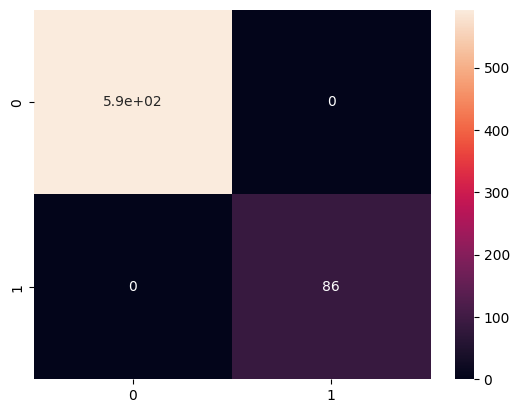

In [ ]:
sns.heatmap(cm_lgbm, annot=True)

# Supermodel building

## normalizing the sprmdl_meta df

In [62]:
sprmdl_meta.head()

,image_code,target,clin_size_long_diam_mm,tbp_lv_A,tbp_lv_Aext,tbp_lv_B,tbp_lv_Bext,tbp_lv_C,tbp_lv_Cext,tbp_lv_H,tbp_lv_Hext,tbp_lv_L,tbp_lv_Lext,tbp_lv_areaMM2,tbp_lv_area_perim_ratio,tbp_lv_color_std_mean,tbp_lv_deltaA,tbp_lv_deltaB,tbp_lv_deltaL,tbp_lv_deltaLB,tbp_lv_deltaLBnorm,tbp_lv_eccentricity,tbp_lv_minorAxisMM,tbp_lv_nevi_confidence,tbp_lv_norm_border,tbp_lv_norm_color,tbp_lv_perimeterMM,tbp_lv_radial_color_std_max,tbp_lv_stdL,tbp_lv_stdLExt,tbp_lv_symm_2axis,tbp_lv_symm_2axis_angle,tbp_lv_x,tbp_lv_y,tbp_lv_z,tbp_lv_dnn_lesion_confidence,anatom_enc,age_enc,n_images,n_images_enc,tbp_tile_type_enc,iddx_full_enc,iddx_1_enc,tbp_lv_location_enc,tbp_lv_location_simple_enc
0,ISIC_6816024,0,3.60,17.403980,9.359642,32.728310,27.611985,37.068057,29.155182,61.997232,71.274869,49.147174,59.318115,7.262150,16.571909,1.518484,8.044337,5.116325,-10.170941,11.485284,8.490698,0.745669,2.499998,99.789667,2.361088,4.507353,10.970310,1.489583,3.316372,2.068222,0.220183,40,-89.032990,1099.248657,-136.759766,100.000000,0,8,1,0,0,0,0,18,6
1,ISIC_7179031,0,3.29,19.807330,15.694290,26.838100,25.990200,33.355870,30.361180,53.571550,58.874140,25.097420,32.273560,5.967348,15.966200,0.430872,4.113040,0.847902,-7.176132,7.343341,7.945036,0.771062,2.191781,89.749210,2.369807,1.322378,9.760936,0.451078,1.917072,1.125674,0.236264,55,-258.351900,1296.501000,147.697500,99.999920,5,8,2,0,0,0,0,3,1
2,ISIC_9836856,0,4.58,16.896179,13.025438,22.348817,21.733907,28.016967,25.338207,52.909947,59.065145,22.629900,29.198839,8.069056,23.681788,1.071097,3.870740,0.614910,-6.568940,6.713932,7.832114,0.897321,2.192788,2.661496,3.716402,3.622970,13.823519,1.341007,2.356845,2.044722,0.228216,10,416.137512,1247.750732,112.024902,92.036825,5,13,16,2,0,0,0,3,1
3,ISIC_4062757,0,2.88,21.487189,15.261616,24.046405,19.921275,32.247928,25.095301,48.216925,52.544407,55.708370,64.886441,4.822668,15.548284,0.717553,6.225573,4.125130,-9.178072,10.145551,6.854720,0.685693,2.054795,76.106584,1.951989,2.087786,8.659343,0.676317,2.781081,1.946605,0.190141,85,199.871033,631.030701,156.308380,99.999964,2,3,4,0,1,0,0,12,4
4,ISIC_5910482,0,2.90,16.094396,9.974178,23.528442,21.773732,28.506441,23.949523,55.626310,65.388286,34.398283,48.485230,6.661663,14.011395,2.946391,6.120218,1.754710,-14.086946,14.449472,12.268974,0.441474,2.670960,99.316484,1.630953,7.998123,9.661221,2.401003,6.121249,2.103177,0.184615,170,77.189575,635.162598,93.152832,100.000000,2,9,7,0,0,0,0,6,2


In [83]:
sprmdl_meta_features = sprmdl_meta.drop(columns=["image_code", "target"])
sprmdl_meta_target = sprmdl_meta["target"]
sprmdl_meta_key = sprmdl_meta["image_code"]

In [66]:
scaler.fit(sprmdl_meta_features)

StandardScaler()

In [84]:
sprmdl_meta_features_norm = scaler.transform(sprmdl_meta_features)

sprmdl_meta_features_norm = pd.DataFrame(sprmdl_meta_features_norm, columns = sprmdl_meta_features.columns)

In [89]:
sprmdl_meta_features_norm['image_code'] = sprmdl_meta_key

sprmdl_meta_features_norm.head()

,clin_size_long_diam_mm,tbp_lv_A,tbp_lv_Aext,tbp_lv_B,tbp_lv_Bext,tbp_lv_C,tbp_lv_Cext,tbp_lv_H,tbp_lv_Hext,tbp_lv_L,tbp_lv_Lext,tbp_lv_areaMM2,tbp_lv_area_perim_ratio,tbp_lv_color_std_mean,tbp_lv_deltaA,tbp_lv_deltaB,tbp_lv_deltaL,tbp_lv_deltaLB,tbp_lv_deltaLBnorm,tbp_lv_eccentricity,tbp_lv_minorAxisMM,tbp_lv_nevi_confidence,tbp_lv_norm_border,tbp_lv_norm_color,tbp_lv_perimeterMM,tbp_lv_radial_color_std_max,tbp_lv_stdL,tbp_lv_stdLExt,tbp_lv_symm_2axis,tbp_lv_symm_2axis_angle,tbp_lv_x,tbp_lv_y,tbp_lv_z,tbp_lv_dnn_lesion_confidence,anatom_enc,age_enc,n_images,n_images_enc,tbp_tile_type_enc,iddx_full_enc,iddx_1_enc,tbp_lv_location_enc,tbp_lv_location_simple_enc,image_code
0,-0.229568,-0.659692,-1.527132,0.869331,0.179426,0.404040,-0.367849,1.289817,1.755037,0.647539,0.686469,-0.197381,-0.466756,0.448483,1.155921,1.641049,-0.301548,0.503704,0.289613,0.051605,-0.110218,1.519733,-0.640835,0.562346,-0.205667,0.501073,0.278881,-0.308263,-0.696163,-0.901286,-0.445562,0.124106,-2.159155,0.300982,-1.447760,-0.282100,-0.732982,-0.504809,-0.656997,-0.312078,-0.361939,1.160238,1.084166,ISIC_6816024
1,-0.370725,-0.103545,0.125123,-0.186411,-0.171829,-0.221501,-0.125473,-0.042468,-0.249034,-1.554249,-1.583729,-0.293026,-0.574604,-0.794918,-0.356757,-0.100652,0.515829,-0.615382,0.092473,0.228865,-0.320916,1.276745,-0.635826,-0.839855,-0.365325,-0.744209,-0.467291,-1.527753,-0.568171,-0.616736,-1.335121,0.603816,1.027205,0.300976,1.674697,-0.282100,-0.646795,-0.504809,-0.656997,-0.312078,-0.361939,-1.534154,-1.613528,ISIC_7179031
2,0.216669,-0.777200,-0.570989,-0.991056,-1.093680,-1.121161,-1.134968,-0.147081,-0.218166,-1.780153,-1.841830,-0.137776,0.799169,-0.062987,-0.449989,-0.195723,0.681551,-0.785438,0.051676,1.110258,-0.320228,-0.830855,0.137783,0.172992,0.171006,0.322914,-0.232784,-0.338668,-0.632229,-1.470388,2.208475,0.485257,0.627617,-0.227126,1.674697,1.625364,0.559821,0.749084,-0.656997,-0.312078,-0.361939,-1.534154,-1.613528,ISIC_9836856
3,-0.557416,0.285183,0.012269,-0.686786,-1.486270,-0.408201,-1.183786,-0.889151,-1.271977,1.248225,1.153890,-0.377581,-0.649014,-0.467173,0.456100,1.236598,-0.030563,0.141730,-0.301443,-0.367079,-0.414561,0.946581,-0.875859,-0.502880,-0.510754,-0.474123,-0.006562,-0.465614,-0.935291,-0.047635,1.072266,-1.014582,1.123660,0.300979,-0.198777,-2.189565,-0.474422,-0.504809,1.522076,-0.312078,-0.361939,0.082481,0.005088,ISIC_4062757
4,-0.548310,-0.962737,-1.366844,-0.779623,-1.085055,-1.038680,-1.414059,0.282435,0.803711,-0.702742,-0.222875,-0.241738,-0.922660,2.080924,0.415561,0.269365,-1.370349,1.304580,1.654651,-2.071928,0.006653,1.508282,-1.060292,2.099176,-0.378489,1.593967,1.774570,-0.263038,-0.979271,1.564818,0.427729,-1.004534,0.416221,0.300982,-0.198777,0.099393,-0.215861,-0.504809,-0.656997,-0.312078,-0.361939,-0.995276,-1.073989,ISIC_5910482


merge meta & images dfs

In [100]:
supermodel_df = pd.merge(sprmdl_meta_features_norm, image_df, on='image_code')
supermodel_df.to_csv('supermodel_df.csv', index=False)

Prepare the data that will feed the supermodel

In [93]:
image_columns = list(map(str, range(1024)))
metadata_columns = [col for col in supermodel_df.columns if col not in image_columns + ['image_code', 'target']]

image_data = supermodel_df[image_columns].values
metadata_features = supermodel_df[metadata_columns].values
labels = supermodel_df['target'].values

In [102]:
# Define CNN model using API
inputs = Input(shape=(1024,))
x = Reshape((32, 32, 1))(inputs)
x = Conv2D(16, 3, padding='same', activation='relu')(x)
x = MaxPooling2D()(x)
x = Conv2D(32, 3, padding='same', activation='relu')(x)
x = MaxPooling2D()(x)
x = Conv2D(64, 3, padding='same', activation='relu')(x)
x = MaxPooling2D()(x)
x = Conv2D(128, 3, padding='same', activation='relu')(x)
x = MaxPooling2D()(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
outputs = Dense(2)(x)

img_model = Model(inputs=inputs, outputs=outputs)
img_model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy', 'mse'])


dummy_input = np.zeros((1, 1024)) # Call the model on some dummy data to ensure it is built
img_model.predict(dummy_input)

feature_extractor = Model(inputs=img_model.input, outputs=img_model.layers[-2].output)

supermodel_df = pd.read_csv('supermodel_df.csv')  #load the data

image_columns = list(map(str, range(1024)))
metadata_columns = [col for col in supermodel_df.columns if col not in image_columns + ['image_code', 'target']]

image_data = supermodel_df[image_columns].values
metadata_features = supermodel_df[metadata_columns].values
labels = supermodel_df['target'].values


cnn_features = feature_extractor.predict(image_data) #Extract features


combined_features = np.hstack((cnn_features, metadata_features)) # Combine CNN features with metadata


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


In [111]:
lgbm_params = {
    "learning_rate": 0.05,
    "boosting_type": "dart", #dart has been shown to prevent overfitting (see documentation)
    "objective": "binary",
    "metric": ["auc", "binary_logloss"],
    "num_leaves": 100,
    "max_depth": 10,
    'verbosity': -1
    }

N_FOLDS = 10
folds = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=42)

oof = np.zeros(len(combined_features))
sub = np.zeros(len(combined_features)) 

scores = [0 for _ in range(folds.n_splits)]

for fold_, (train_idx, val_idx) in enumerate(folds.split(combined_features, labels)):
    X_train, y_train = combined_features[train_idx], labels[train_idx]
    X_val, y_val = combined_features[val_idx], labels[val_idx]
    
    train_data = lgb.Dataset(X_train, label=y_train)
    val_data = lgb.Dataset(X_val, label=y_val)
    watchlist = [train_data, val_data]
    
    clf = lgb.train(lgbm_params, train_set=train_data, valid_sets=watchlist, num_boost_round=50)
    
    oof[val_idx] = clf.predict(X_val)
    sub += clf.predict(combined_features) / folds.n_splits
    
    scores[fold_] = roc_auc_score(y_val, oof[val_idx])
    print("Fold {}: {}".format(fold_ + 1, round(scores[fold_], 5)))

print("CV AUC: {:.5f}".format(roc_auc_score(labels, oof)))

Fold 1: 1.0
Fold 2: 1.0
Fold 3: 1.0
Fold 4: 1.0
Fold 5: 1.0
Fold 6: 1.0
Fold 7: 1.0
Fold 8: 1.0
Fold 9: 1.0
Fold 10: 1.0
CV AUC: 1.00000
